# Saving Intermediate Results with MultiResult

This notebook demonstrates the MultiResult feature of openEO, which enables retrieving multiple results from a single process call. Unlike the approach used in [ForestFire.ipynb](ForestFire.ipynb), we perform the same analysis in this notebook but optimize the workflow by using MultiResult to download all results in one step instead of saving intermediate outputs separately.

Therefore, the main objective of this notebook is:

* Showcase the usage of MultiResult in the openEO Python Client.
* Optimize the forest fire analysis workflow by reducing redundant result-saving steps.

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import openeo
from openeo import MultiResult

Authenticating with the openEO backend and loading the required data is the same as in the [ForestFire.ipynb](ForestFire.ipynb) notebook.

In [2]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [3]:
extent = {"west": -2.6910, "south": 38.2239, "east": -2.5921, "north": 38.3002}

As done in the previous notebook, we use the concept of BAP which means the best available cloud-free pixels right before or right after the forest fire event, this is obtained via cloud masking and temporal reduction with "first" in post event datacube and "last" in pre event datacube date.

In [4]:
# define a function to identify cloud-free pixels in the available data-cube


def getBAP(scl, data, reducer="first"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

Firstly, calculate the pre-event NDVI

In [5]:
# load S2 pre-collection
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-03", "2017-08-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2pre_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-03", "2017-08-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate ndvi
ndvi_pre = s2pre.ndvi()
# Create a Pre-event cloud free mosiac
ndvi_pre = getBAP(s2pre_scl, ndvi_pre, reducer="last")

Before initiating the actual execution on the backend, we explicitly save the intermediate results with a specific name and format.

In [6]:
# first result
ndvi_pre = ndvi_pre.save_result(format="GTiff", options={"filename_prefix": "NDVI"})

Next, we calculate the NDVI in Near Real-Time (NRT) mode, following a similar approach as before but with differences in the type of reducer used and the temporal extent of the data cube.

In [7]:
# load S2 Near-real-time(NRT) collection
s2nrt = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-08-08"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2nrt_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-08-08"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)
ndvi_nrt = s2nrt.ndvi()
ndvi_nrt = getBAP(s2nrt_scl, ndvi_nrt, reducer="first")

Similarly, to get this as an additional result for visualisation, let's also save this result as an intermediate result.

In [8]:
# second result
ndvi_nrt = ndvi_nrt.save_result(format="GTiff", options={"filename_prefix": "ndvi_nrt"})

Then, we calculate the difference between the pre-event and post-event NDVI to pinpoint the areas impacted by the forest fire.

In [9]:
# load S2 post collection
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-11-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2post_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-11-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate post ndvi mosaic
ndvi_post = s2post.ndvi()
ndvi_post = getBAP(s2post_scl, ndvi_post, reducer="first")

In [10]:
# final result
ndvi_post = ndvi_post.save_result(
    format="GTiff", options={"filename_prefix": "Post_NDVI"}
)

Finally, a single job is created to handle multiple results. 

The MultiResult object is used to group the pre-event, Near Real-Time (NRT), and post-event NDVI data. Then, a job is started using as shown below:

In [12]:
multi_result = MultiResult([ndvi_pre, ndvi_nrt, ndvi_post])
job = multi_result.create_job(title="Multiple save result")
job.start_and_wait()

0:00:00 Job 'j-2502031235124c8ba0ffe3fef88bd282': send 'start'
0:00:14 Job 'j-2502031235124c8ba0ffe3fef88bd282': created (progress 0%)
0:00:21 Job 'j-2502031235124c8ba0ffe3fef88bd282': created (progress 0%)
0:00:27 Job 'j-2502031235124c8ba0ffe3fef88bd282': created (progress 0%)
0:00:35 Job 'j-2502031235124c8ba0ffe3fef88bd282': created (progress 0%)
0:00:45 Job 'j-2502031235124c8ba0ffe3fef88bd282': created (progress 0%)
0:00:58 Job 'j-2502031235124c8ba0ffe3fef88bd282': running (progress N/A)
0:01:13 Job 'j-2502031235124c8ba0ffe3fef88bd282': running (progress N/A)
0:01:32 Job 'j-2502031235124c8ba0ffe3fef88bd282': running (progress N/A)
0:01:56 Job 'j-2502031235124c8ba0ffe3fef88bd282': running (progress N/A)
0:02:26 Job 'j-2502031235124c8ba0ffe3fef88bd282': running (progress N/A)
0:03:03 Job 'j-2502031235124c8ba0ffe3fef88bd282': running (progress N/A)
0:03:50 Job 'j-2502031235124c8ba0ffe3fef88bd282': running (progress N/A)
0:04:49 Job 'j-2502031235124c8ba0ffe3fef88bd282': finished (progre

<BatchJob job_id='j-2502031235124c8ba0ffe3fef88bd282'>

In [13]:
results = job.get_results()
results.download_files("data/out")

[PosixPath('data/out/NDVI.tif'),
 PosixPath('data/out/Post_NDVI.tif'),
 PosixPath('data/out/ndvi_nrt.tif'),
 PosixPath('data/out/job-results.json')]

### Plot the results

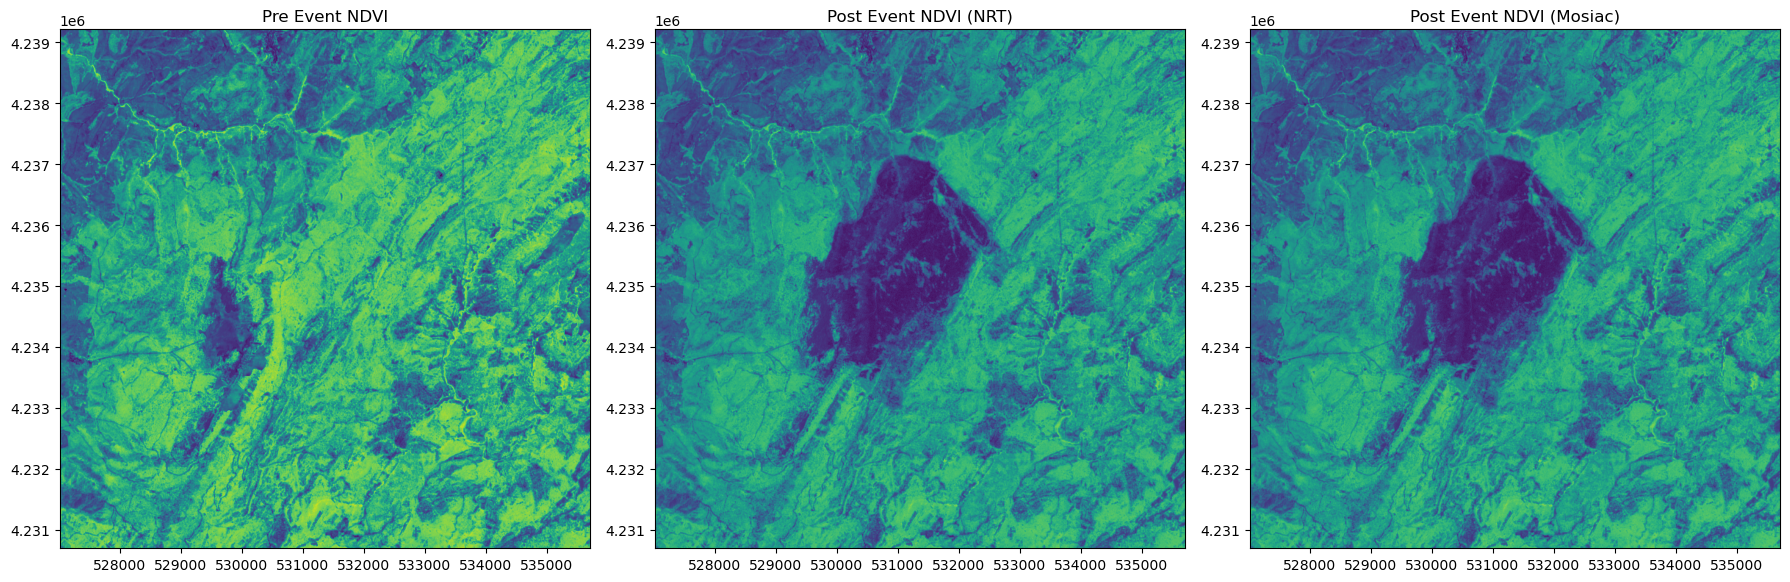

In [15]:
ndvi = rasterio.open("data/out/NDVI.tif")
ndvi_nrt = rasterio.open("data/out/ndvi_nrt.tif")
ndvi_mosiac = rasterio.open("data/out/Post_NDVI.tif")

f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(ndvi.read(1), vmin=0, vmax=1, transform=ndvi.transform, ax=axarr[0])
axarr[0].set_title("Pre Event NDVI")

im = show(ndvi_nrt.read(1), vmin=0, vmax=1, transform=ndvi_nrt.transform, ax=axarr[1])
axarr[1].set_title("Post Event NDVI (NRT)")

im = show(
    ndvi_mosiac.read(1), vmin=0, vmax=1, transform=ndvi_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post Event NDVI (Mosiac)")
plt.tight_layout()